# CAP 5768 - Data Science - Dr. Marques - Fall 2019

Christian Garbin

## Assignment 4: Statistical analysis - Part 2
## Starter code

### Goals 

- To practice the computation and displaying of representative statistical distributions.
- To expand upon the prior experience of manipulating, summarizing, and visualizing small datasets.
- To compute moments and skewness measures.
- To increase our statistical analysis skills.
- To estimate the parameters of a distribution and propose a model that explains the underlying data.


### Instructions

- This assignment is structured in 3 parts, each one using their own dataset(s).
- As usual, there will be some Python code to be written and questions to be answered.
- At the end, you should export your notebook to PDF format; it will become your report.
- Submit the report (PDF), notebook (.ipynb file), and (optionally) link to the "live" version of your solution on Google Colaboratory via Canvas.
- The total number of points is 142 (plus up to 40 bonus points).

### Important

- It is OK to attempt the bonus points, but please **do not overdo it!** 

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

-------------------
## Part 1: Representative analytic distributions

In this part we will look at how to generate and plot analytic distributions.

The Python code below generates and plots the PDF and CDF of a normal (Gaussian) distribution whose parameters are *mu* and *sigma*.

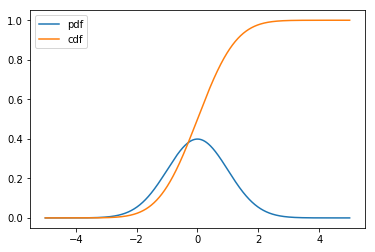

In [2]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

y_pdf = ss.norm.pdf(x, mu, sigma) # the normal pdf
y_cdf = ss.norm.cdf(x, mu, sigma) # the normal cdf

plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend();

## Your turn! (12 points, i.e., 6 pts each)

Write code to:

1. Plot the PDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot. 
They will probably look like this:

![PDF](notebook_images/pdf-example.png)

2. Plot the CDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot.
They will probably look like this:

![CDF](notebook_images/cdf-example.png)

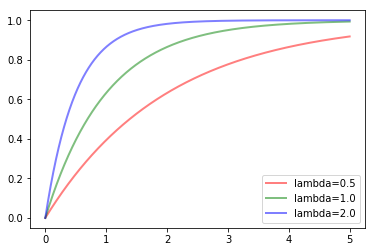
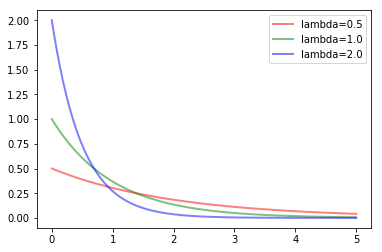

## Solution

In [3]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

-------------------
## Part 2: Empirical distributions vs. analytic distributions

The question we are trying to answer in this part is: **How well can we model empirical distributions with analytic distributions?**

Let's start by asking the question **Are the Belmont Stakes results normally distributed?**

*For context: Since 1926, the Belmont Stakes is a 1.5 mile-long race of 3-year old thoroughbred horses. Secretariat ran the fastest Belmont Stakes in history in 1973. While that was the fastest year, 1970 was the slowest because of unusually wet and sloppy conditions. These two outliers have been removed from the data set, which has been obtained by scraping the Belmont Wikipedia page.* (The file ``belmont.csv`` is available on Canvas, if you want to learn more about the race's results.)

The code below:
- computes mean and standard deviation of Belmont winners' times with the two outliers removed.
- takes 10,000 samples out of a normal distribution with this mean and standard deviation using
``np.random.normal()``.
- computes the CDF of the theoretical samples and the ECDF of the Belmont winners' data, assigning the results to x_theor, y_theor and x, y, respectively.
- plots the CDF of your samples with the ECDF, with labeled axes.

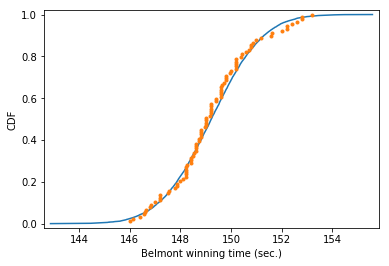

In [4]:
import numpy as np
import matplotlib.pyplot as plt

belmont_no_outliers = np.array([148.51,  146.65,  148.52,  150.7,  150.42,  150.88,  151.57,
                                147.54,  149.65,  148.74,  147.86,  148.75,  147.5,  148.26,
                                149.71,  146.56,  151.19,  147.88,  149.16,  148.82,  148.96,
                                152.02,  146.82,  149.97,  146.13,  148.1,  147.2,  146.,
                                146.4,  148.2,  149.8,  147.,  147.2,  147.8,  148.2,
                                149.,  149.8,  148.6,  146.8,  149.6,  149.,  148.2,
                                149.2,  148.,  150.4,  148.8,  147.2,  148.8,  149.6,
                                148.4,  148.4,  150.2,  148.8,  149.2,  149.2,  148.4,
                                150.2,  146.6,  149.8,  149.,  150.8,  148.6,  150.2,
                                149.,  148.6,  150.2,  148.2,  149.4,  150.8,  150.2,
                                152.2,  148.2,  149.2,  151.,  149.6,  149.6,  149.4,
                                148.6,  150.,  150.6,  149.2,  152.6,  152.8,  149.6,
                                151.6,  152.8,  153.2,  152.4,  152.2])

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

# Seed random number generator
np.random.seed(42)

# Compute mean and standard deviation: mu, sigma
mu = np.mean(belmont_no_outliers)
sigma = np.std(belmont_no_outliers)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(belmont_no_outliers)

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Belmont winning time (sec.)')
_ = plt.ylabel('CDF')
plt.show()


## Questions 1-2 (6 points, i.e., 3 pts each)

1. Does the empirical distribution of the data resemble a normal distribution? 
2. What other *plots* could you produce to better investigate (visually) the claim that the Belmont Stakes results are normally distributed? 

## Solution

(ENTER YOUR ANSWER HERE)

## BONUS (20 points)

Let's try to answer the question: **What are the chances of a horse matching or beating Secretariat's record?**

Assuming that the Belmont winners' times are Normally distributed (with the 1970
and 1973 years removed), write Python code to answer the question: *What is the probability that the winner of a given Belmont Stakes will run it as fast or faster than Secretariat?*

Instructions:
- Take 1,000,000 samples from the normal distribution using the ``np.random.normal()`` function.
- Compute the mean ``mu`` and standard deviation ``sigma`` from the ``belmont_no_outliers`` array. 
- Compute the fraction of samples that have a time less than or equal to Secretariat's time of 144 seconds.
- Print the result.

## Solution

In [5]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

## Your turn (30 points)

Let's investigate whether the speed of light measurements by Michelson are normally distributed.

The dataset (``michelson_speed_of_light.csv``) is available on Canvas. 
Hint: You are only interested in the *velocity of light in air (km/s)* column.

You should follow a similar sequence of steps as above, namely:
- Compute the mean ``mu`` and standard deviation ``sigma`` from the ``michelson_speed_of_light`` array. 
- Take 10,000 samples out of a normal distribution with this mean and standard deviation using
``np.random.normal()``.
- Compute the CDF of the theoretical samples and the ECDF of the Michelson speed of light data, assigning the results to ``x_theor``, ``y_theor`` and ``x, y``, respectively.
- Plot the CDF of your samples with the ECDF, with labeled axes.

For more on Michelson: https://en.wikipedia.org/wiki/Albert_A._Michelson

## Solution

In [6]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

## Questions 3-4 (6 points, i.e., 3 pts each)

3. Does the empirical distribution of the data resemble a normal distribution? 
4. What other *plots* could you produce to better investigate (visually) the claim that the Michelson speed of light measurements are normally distributed? 

## Solution

(ENTER YOUR ANSWER HERE)

## Your turn (30 points)

Next, let's turn our attention to baby births.

In the real world, exponential distributions come up when we look at a series of events and measure the times between events, called *interarrival times*. If the events are equally likely to occur at any time, the distribution of interarrival times tends to look like an exponential distribution.

We will use the dataset from ``babies_brisbane.csv`` containing information about the time of birth for  44 babies born in a hospital in Brisbane, Australia, on December 18, 1997, as reported in the local paper. 

You should write code to:
1. Read the data and build a Pandas dataframe.
2. Compute the reciprocal of the mean of the sample exponential distribution (call this ``lam``, since ``lambda`` is a reserved word in Python).
3. Take 10,000 samples out of an exponential distribution with this scale using
``np.random.exponential()``.
4. Compute the CDF of the theoretical samples and the ECDF of the sample data, assigning the results to ``x_theor``, ``y_theor`` and ``x, y``, respectively.
5. Plot the CDF of your samples with the ECDF, with labeled axes.
6. Compute the Complementary CDF (CCDF) and plot the CCDF for both theoretical and sample values, on a log-y scale. (See Figure 5-2 in the textbook)

## Solution

In [7]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

-------------------
## Part 3: Moments and skewness

Let's revisit the dataset of salaries from Assignment 1 and use it to measure skewness.

In [8]:
salaries = pd.read_csv('data/salaries.csv')
salaries.describe()

,earn,height,ed,age
count,1192.000000,1192.000000,1192.000000,1192.000000
mean,23154.773490,66.915154,13.504195,41.378356
std,19472.296925,3.853968,2.420175,15.867428
min,200.000000,57.503219,3.000000,18.000000
25%,10000.000000,64.009746,12.000000,29.000000
50%,20000.000000,66.451265,13.000000,38.000000
75%,30000.000000,69.848100,16.000000,51.000000
max,200000.000000,77.051282,18.000000,91.000000


# Your turn (32 points, i.e., 8 pts each)

Write Python code to:
1. Compute the median and mean salary for the entire sample.
2. Compute the first raw moment and show that it is equivalent to computing the mean value.
3. Compute the second central moment and show that it is equivalent to computing the variance.
4. Compute the skewness using ``scipy.stats.skew``

## Solution

In [9]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

## Question 5 (6 points)

5. How do you interpret the value of skewness computed by your code?

## Solution

(ENTER YOUR ANSWER HERE)

## Bonus! (20 points)

Write code to repeat the steps above, this time for male and female employees separately.

## Solution

In [10]:
# ENTER YOUR CODE HERE
# ...
# ...
# ...

## Conclusions (20 points)

Write your conclusions and make sure to address the issues below:
- What have you learned from this assignment?
- Which parts were the most fun, time-consuming, enlightening, tedious?
- What would you do if you had an additional week to work on this?

## Solution

(WRITE YOUR CONCLUSIONS HERE)